# The Geography of Startup Success: The Effect of Proximity To Universities On Startups' Investment Success. 
### by Jessica Dowuona-Owoo

# Project 1

## Introduction

It is almost intuitive to believe there is some form of significance to startups of being located near a university. The location of a startup is one of the most important endogenous factors that businesses consider, and this paper seeks to determine the relationship between proximity to universities and start-up investment success.

When it comes to the relationship between education and startup success there are many aspects to consider to determine relationships. A look into the effect of the education of the founder and the entrepreneurial success shows that generally the more educated a founder is the more successful they are at securing funds however, it was also discovered that too much funding may rather reduce the funding received (Everett, C. R., 2024). 

Many studies have been done focusing on a particular relationship between universities and startups (or innovation), for example, determining the role universities specialized in technical fields, say engineering and applied science (Bonaccorsi et al., 2013), have on startup creation or start-up operations in general (Fritsch & Aamoucke, 2017) or the innovative capacities of the startup (Allen, T. J., et. al, 2016). Other studies show positive spillovers between research universities and innovation by providing research and development (R&D) initiatives (Anselin et al., 1997). Additionally, some papers show an opposing correlation to fields of study that may have been seen to be the more attractive (Audretsch et al., 2005). Further studies also look at the role of access to knowledge bases in determining the type of startups that are created in the area (Baptista et al., 2010). This research seeks to explore the unanswered question of proximity's effect on specifically investment success as opposed to the broader success of a startup or a sector of a startup.

Additionally it is also worth noting that educational bases may interact with other variables like VC market competition to fully grasp the success of investments (Hong, S, Serfes, K, Thiele, V., 2020). The insight from startup founders also lets us know what other factors aside location they deem as important for funding success (Prohorovs, A. et al., 2019). 

To answer our question, we will use a startup investments data set (Justinas Cirtautas, 2020), which contains information on start-ups from 1980 to 2014, and all universities data (Work WIth Data, 2025), which includes ranking, population, founding year and other information about universities. The focus of this paper is to look at the US, Canada and China, due to the data provided in the dataset. Thus, we will consider universities and startups in the US. With this data we will explore the relationship between proximity and investment success. Insights from this paper, when combined with other startup success determiners like the fused large language model (Maarouf, A. et al., 2025) helps startups and investors to make more informed decisions in the early stages of their life span.

### Variable Decisions

The chosen Y variable is investment success- expressed as the total investment raised. However other variables will be used as a proxy for investment success due to the nature of their contribution to the company's investment. These include funding rounds and the initial public offering success. With our current data set, these are convenient and easy-to-calculate investment success measures. They are also relatively easy to interpret for example, higher average funding rounds can be indicative of increased investor-investee interactions.

For the x values, we will consider the proximity to universities, the number of startups per state, the funding round type, and the startup age. The number of startups per state tells us the density of startups between states, and studying this x variable may help us discover whether or not the concentration of startups is helpful or detrimental to the average funds that each startup receives. 
The startup age at will tell us what effect the startups age has on investment success.

## Data Cleaning

In [1]:
import matplotlib
import matplotlib.colors as mplc
import matplotlib.patches as patches
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.colors as mcolors
import folium
import us

from matplotlib.colors import ListedColormap
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from geopy.distance import geodesic
from folium.plugins import HeatMap
from shapely.geometry import Point
from geopy.distance import great_circle


In [31]:
#Data from the Startups data set
objects = pd.read_csv('/Users/jessyterlisner/Desktop/ECO225Project/Data/objects.csv', low_memory=False)
investments = pd.read_csv('/Users/jessyterlisner/Desktop/ECO225Project/Data/investments.csv')
office = pd.read_csv('/Users/jessyterlisner/Desktop/ECO225Project/Data/offices.csv')
f_rounds = pd.read_csv('/Users/jessyterlisner/Desktop/ECO225Project/Data/funding_rounds.csv')
ipos = pd.read_csv('/Users/jessyterlisner/Desktop/ECO225Project/Data/ipos.csv')

# renaming values
objects.rename(columns={'id':'funded_object_id'}, inplace=True)
f_rounds.rename(columns={'object_id':'funded_object_id'}, inplace=True)
office.rename(columns={'object_id':'funded_object_id'}, inplace=True)
ipos.rename(columns={'object_id':'funded_object_id'}, inplace=True)


#dropping columns as they become duplicates in the main source file
office = office.drop(columns= ['created_at', 'updated_at', 'country_code', 'state_code', 'region', 'city'], inplace=False)
obj = objects.drop(columns= ['created_at', 'updated_at', 'tag_list', 'logo_height', 'logo_width', 'logo_url', 'created_by', 
                             'twitter_username', 'homepage_url'], inplace= False)
inv = investments.drop(columns= ['created_at', 'updated_at'], inplace=False)
f_rounds = f_rounds.drop(columns = ['source_description', 'created_at', 'updated_at', 'created_by', 'pre_money_valuation', 
                                    'raised_amount','post_money_valuation', 'post_money_currency_code', 
                                    'pre_money_valuation', 'pre_money_currency_code'], inplace=False)

#Merge source files
source = pd.merge(obj, inv, on= 'funded_object_id')
#source = pd.merge(source, f_rounds, on= 'funded_object_id')

#merge offices and source to gain location data 
#source = pd.merge(source, office, on= 'funded_object_id')
#source = source.drop_duplicates(subset=['funded_object_id']) # reduce duplication and keep only one office per startup.
#source = source.dropna(subset = ['latitude' , 'longitude'])

#merge ipos and main to get ipo data
#main = source.loc[:, ~source.columns.duplicated()]# Drop duplicate columns
#main = pd.merge(source, ipos, on='funded_object_id', suffixes=('_main', '_ipos'))

# Keep only relevant countries (USA, CAN, CHN)
#main = main[main["country_code"].isin(["USA", "CAN", "CHN"])]

#main.columns


In [32]:
source['country_code'].value_counts()

country_code
USA    57659
GBR     4547
CAN     2084
DEU     1896
FRA     1633
       ...  
PER        1
ALB        1
PST        1
GIN        1
SLV        1
Name: count, Length: 100, dtype: int64

In [19]:
#Choosing only USA
main_usa = main[main["country_code"] == "USA"]

In [20]:
all_uni = pd.read_csv('/Users/jessyterlisner/Desktop/ECO225Project/Data/All universities.csv')
all_uni = all_uni.dropna(subset = ['latitude' , 'longitude'])
all_uni = all_uni.drop(columns= ['logo link', 'domain', 'description'], inplace=False)

In [21]:
# Function to calculate distance between two points using latitude and longitude
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

# Calculate the distance between each startup and the nearest university within the same state
distances = []
for i, startup in main.iterrows():
    min_distance = float('inf')
    for j, university in all_uni.iterrows():
        if startup['city'] == university['city']:
            distance = calculate_distance(startup['latitude'], startup['longitude'], university['latitude'], university['longitude'])
            if distance < min_distance:
                min_distance = distance
    distances.append(min_distance if min_distance != float('inf') else None)

# Add the distances to the startup data
main['distance_to_nearest_university'] = distances

# Drop rows where distance could not be calculated (i.e., no university in the same state)
main = main.dropna(subset=['distance_to_nearest_university'])

## Summary Statistics Tables

In [23]:
pd.set_option('display.float_format', '{:.2f}'.format)
summary = main.describe().T
summary = summary.loc[['investment_rounds', 'invested_companies', 'funding_rounds', 'funding_total_usd']]
# Drop the 25% and 75% columns
summary = summary.drop(columns=["25%", "75%"])
summary.head()

count         mean          std  min         50%  \
investment_rounds  138.00         1.88         9.10 0.00        0.00   
invested_companies 138.00         1.55         7.49 0.00        0.00   
funding_rounds     138.00         3.51         2.64 1.00        3.00   
funding_total_usd  138.00 161254857.59 393957562.53 0.00 54124998.50   

                             max  
investment_rounds          89.00  
invested_companies         73.00  
funding_rounds             13.00  
funding_total_usd  3985050000.00

This table shows that the funding total is skewed- few companies receiving billions, pull the mean up. Investment rounds and invested companies have either zeros or missing data which affect the calculation of these values.

In [25]:
# Group by state and compute total & average funding rounds, and number of companies
summary_table = main.groupby("state_code").agg(
    Total_Funding_Rounds=('funding_rounds', 'sum'),
    Avg_Funding_Rounds=('funding_rounds', 'mean'),
    Num_Companies=('funded_object_id', 'count')).reset_index()

# Define the threshold for High vs. Low company counts (median-based threshold)
threshold = summary_table["Num_Companies"].median()  

# Create a new column classifying each state as "High" or "Low"
summary_table["Company_Group"] = summary_table["Num_Companies"].apply(
    lambda x: "High" if x >= threshold else "Low")

# Group by the High/Low classification
final_summary = summary_table.groupby("Company_Group").agg(
    Total_Funding_Rounds=('Total_Funding_Rounds', 'sum'),
    Avg_Funding_Rounds=('Avg_Funding_Rounds', 'mean'),
    Num_Companies=('Num_Companies', 'sum')).reset_index()

final_summary.head()

Company_Group  Total_Funding_Rounds  Avg_Funding_Rounds  Num_Companies
0          High                   421                3.71            118
1           Low                    34                3.78              9

As suggested, this table which gives the average funding rounds per companies by state has been grouped between high and low number of companies. These values are necessary as a priliminary introduction to the role of location in startup success. As demonstrated in the table, the more startups that exist the greater the average funding round and the larger the total funding.

## Plots 

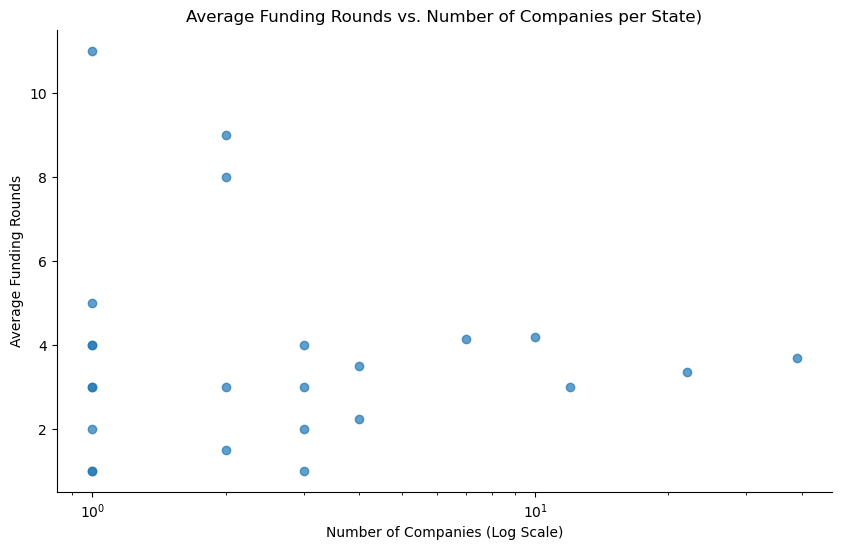

In [28]:
# 1. Scatter Plot – Average Funding Rounds by State 
#filtered_data = summary_table_1[summary_table_1["Num_Companies"] < 100000]  # Adjusted threshold to remove outlier
plt.figure(figsize=(10, 6))
plt.scatter(summary_table["Num_Companies"], summary_table["Avg_Funding_Rounds"], alpha=0.7)

plt.xscale('log')  # Log scale for the X-axis
plt.yscale('linear')  # Keep Y-axis linear

# Remove the right and top spines
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Labels and title
plt.xlabel("Number of Companies (Log Scale)")
plt.ylabel("Average Funding Rounds")
plt.title("Average Funding Rounds vs. Number of Companies per State)")

plt.show()

The scatter plot above tells the relationship between the number of startups per state and the average funding rounds per state. The trend suggests that states with more startups see a higher and or consistent funding rounds on average. The plot has been ajusted in scale to remove the one outlier identified. This relationship may be as a result of concentration of investors around major states. While it was suggested to use a companies per 100k. I did struggle to find the population for the period of the dataset I will endeavour to improve on it before the final submission. 

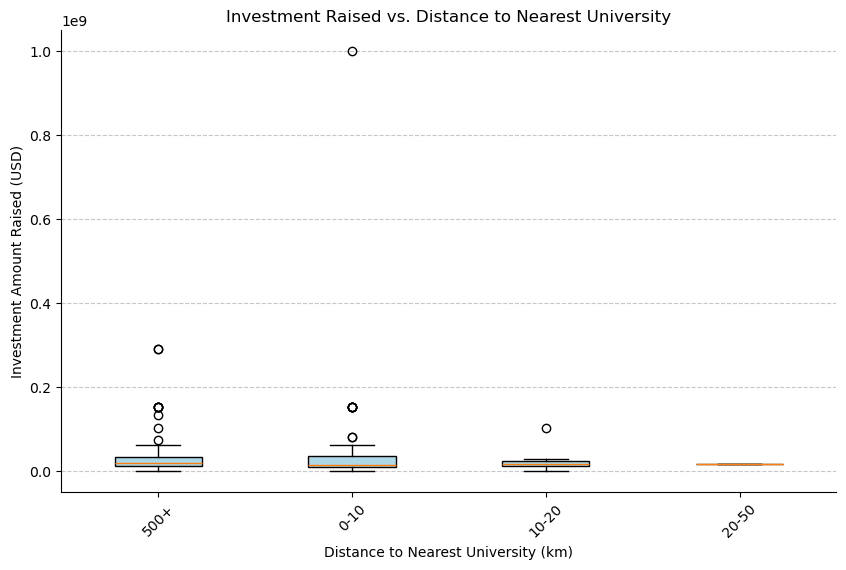

In [30]:
# Define bins for distance ranges
bins = [0, 10, 20, 50, 100, 200, 500, np.inf]  # Distance ranges in km
tick_labels = ["0-10", "10-20", "20-50", "50-100", "100-200", "200-500", "500+"]

# Assign each startup to a distance bin
main['distance_bin'] = pd.cut(main['distance_to_nearest_university'], bins=bins, labels=tick_labels, right=False)

summary_table_2 = main.groupby("city").agg(
    Total_Amt_Raised=('raised_amount_usd', 'sum'),
    Avg_Amt_Raised=('raised_amount_usd', 'mean'),
    Num_Companies=('funded_object_id', 'count') )

summary_table_2 = summary_table_2.reset_index()

# Merge the startup data with the summary table
merged = main.merge(summary_table_2, on="city", how="left")

# Ensure sufficient sample size in each bin before plotting
bin_counts = merged['distance_bin'].value_counts()
valid_bins = bin_counts[bin_counts >= 5].index  # Filter bins with at least 5 startups
filtered_data = merged[merged['distance_bin'].isin(valid_bins)]

# Plot the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(
    [filtered_data.loc[filtered_data['distance_bin'] == bin, 'Avg_Amt_Raised'] for bin in valid_bins],
    tick_labels=valid_bins, patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Formatting the plot
plt.xlabel("Distance to Nearest University (km)")
plt.ylabel("Investment Amount Raised (USD)")
plt.title("Investment Raised vs. Distance to Nearest University")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Remove the right and top spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Using this box plot we see the spread and outliers in the amount of investment raised per distance from universities. 

In [32]:
# bins for proximity ranges
bins = [0, 10, 20, 50, 100, 200, 500, np.inf]  # Distance ranges in km
labels = ["0-10", "10-20", "20-50", "50-100", "100-200", "200-500", "500+"]
# Categorize startups into distance bins
main['distance_bin'] = pd.cut(main['distance_to_nearest_university'], bins=bins, labels=labels, right=False)

# Merge startup data with reg_main
merged = main.merge(reg_main, on="state_code", how="left")

# Group by distance bin and compute the average funding rounds
IPOS_summary = merged.groupby("distance_bin")["IPO_Success"].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(IPOS_summary["distance_bin"], IPOS_summary["IPO_Success"], color='darkorange')

# Remove the right and top spines
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Formatting the plot
plt.xlabel("Distance to Nearest University (km)")
plt.ylabel("IPOS Success")
plt.title("IPOS Success vs. Proximity to Top Universities")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

NameError: name 'reg_main' is not defined

The bar chart above would help us visualise what happens to the initial public offering (IPO) as distance increases, it supports the idea that universities boost startup ecosystems. However this graph shows that the IPO varies only slightly, we can determine that distance may not have much of an effect on IPO of startups.

In [ ]:
# Plot the line chart
plt.figure(figsize=(10, 6))

# Plot Avg Funding Rounds
plt.plot(main['distance_to_nearest_university'], main["participants"], 
          linestyle="-", color="royalblue")

# Formatting the plot
plt.xlabel("Distance to Nearest University (km)")
plt.ylabel("Value")
plt.title("Average Funding Rounds participants vs. Proximity to Universities")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Remove the right and top spines
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

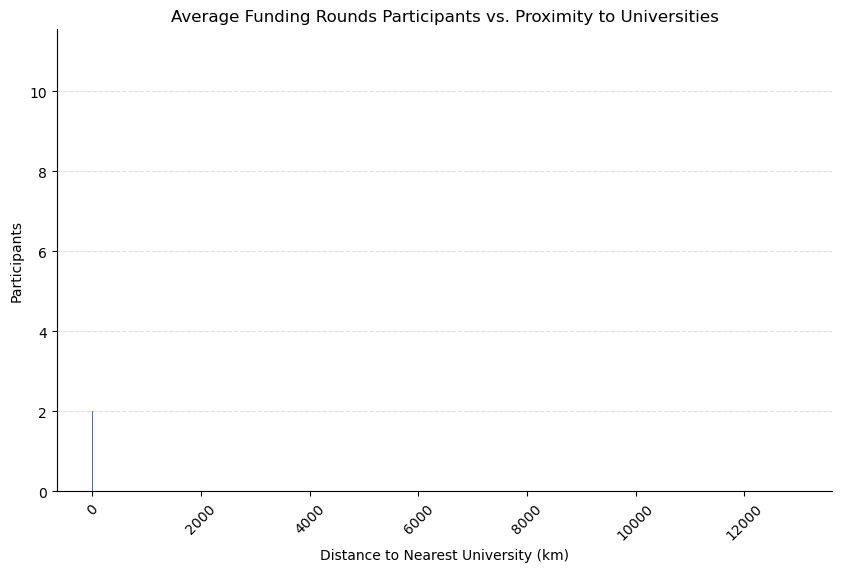

In [43]:
import matplotlib.pyplot as plt

# Plot the bar chart
plt.figure(figsize=(10, 6))

# Plot participants as a bar chart against distance
plt.bar(main['distance_to_nearest_university'], main["participants"], 
        color="royalblue", width=0.8)

# Formatting the plot
plt.xlabel("Distance to Nearest University (km)")
plt.ylabel("Participants")
plt.title("Average Funding Rounds Participants vs. Proximity to Universities")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Remove the right and top spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

This graph maps the number of participants in a funding round to the distance away from universities. We see that there are more participants the further we are from universities. 

# Project Two

## The Message

Startups located closer to universities tend to have lower total funding(USD), suggesting that close proximity to academic hubs may be negatively correlated with investment success.

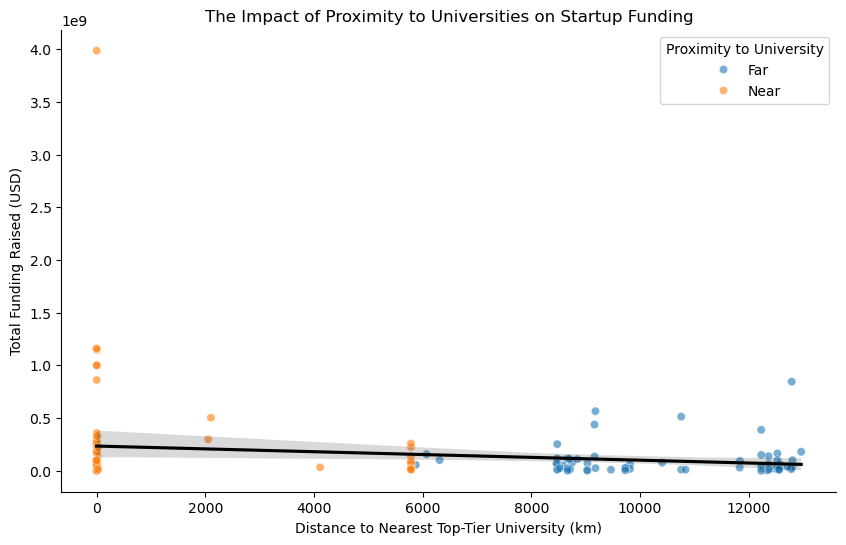

In [45]:
# Create a "Near" vs. "Far" classification based on median distance
median_distance = main['distance_to_nearest_university'].median()
main["Proximity_Group"] = main['distance_to_nearest_university'].apply(lambda x: "Near" if x <= median_distance else "Far")

# Scatter plot with regression trend
plt.figure(figsize=(10, 6))
sns.scatterplot(data=main, x="distance_to_nearest_university", y="funding_total_usd", hue="Proximity_Group", alpha=0.6)
sns.regplot(data=main, x="distance_to_nearest_university", y="funding_total_usd", scatter=False, color="black")

# Remove the right and top spines
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Labels and title
plt.xlabel("Distance to Nearest Top-Tier University (km)")
plt.ylabel("Total Funding Raised (USD)")
plt.title("The Impact of Proximity to Universities on Startup Funding")
plt.legend(title="Proximity to University")

# Show plot
plt.show()

As we can see with the line of best fit there is a negative correlation between proximity to universities and total funds raised by the startup. 

## Maps and Interpretations

### Map 1

In [ ]:
# Load the U.S. states shapefile
us_states = gpd.read_file("https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json")

# Convert state abbreviations to uppercase for merging
main["state_code"] = main["state_code"].str.upper()

# Aggregate total funding per state
state_funding = main.groupby("state_code")["funding_total_usd"].sum().reset_index()

# Rename column for merging
state_funding = state_funding.rename(columns={"state_code": "NAME"})
state_funding["NAME"] = state_funding["NAME"].map(lambda x: us.states.lookup(x).name if us.states.lookup(x) else x)

# Merge with the U.S. states GeoDataFrame
map_data = us_states.merge(state_funding, on="NAME", how="left")

# Remove non-mainland states
excluded_states = ["Alaska", "Hawaii", "Puerto Rico", "Guam", "American Samoa", "Northern Mariana Islands", "U.S. Virgin Islands"]
map_data = map_data[~map_data["NAME"].isin(excluded_states)]

# Create a new column to track NaN/zero values
map_data["color_category"] = map_data["funding_total_usd"].apply(lambda x: "grey" if pd.isna(x) or x == 0 else "purple")

# Set up figure
fig, ax = plt.subplots(figsize=(12, 8))

# Define custom colormap (grey for missing values, Purples for actual funding)
colors = ["grey"] + plt.cm.Purples(np.linspace(0.3, 1, 10)).tolist()
custom_cmap = ListedColormap(colors)

# Plot states with funding data
map_data.dropna(subset=["funding_total_usd"]).plot(
    column="funding_total_usd",
    cmap=custom_cmap,
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    vmin=0, 
    vmax=map_data["funding_total_usd"].max(),
    ax=ax
)

# Plot NaN/zero values in grey
map_data[map_data["color_category"] == "grey"].plot(color="grey", edgecolor="black", ax=ax)

# Remove axes ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Total Funding (USD) by State (Contiguous U.S.)', fontsize=14)

# Adjust layout to fit legend better
plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1)

# Show the plot
plt.show()

This map shows the total funding values that are present in the data set and from this we see that states like California are recipients of higher total funding.  

### Map 2

In [ ]:
# Load the U.S. states shapefile
us_states = gpd.read_file("https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json")

# Convert state abbreviations to uppercase for merging
main["state_code"] = main["state_code"].str.upper()

# Calculate average funding rounds per state
state_funding = main.groupby("state_code")["funding_rounds"].mean().reset_index()

# Rename columns for merging
state_funding = state_funding.rename(columns={"state_code": "NAME"})
state_funding["NAME"] = state_funding["NAME"].map(lambda x: us.states.lookup(x).name if us.states.lookup(x) else x)

# Merge with the U.S. states GeoDataFrame
map_data = us_states.merge(state_funding, on="NAME", how="left")

# Remove non-mainland states
excluded_states = ["Alaska", "Hawaii", "Puerto Rico", "Guam", "American Samoa", "Northern Mariana Islands", "U.S. Virgin Islands"]
map_data = map_data[~map_data["NAME"].isin(excluded_states)]

# Create a new column to track NaN/zero values
map_data["color_category"] = map_data["funding_rounds"].apply(lambda x: "green" if pd.isna(x) or x == 0 else "blue")

# Set up figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot valid funding data using 'Blues' colormap
map_data.dropna(subset=["funding_rounds"]).plot(column="funding_rounds", cmap="Blues", 
                                                linewidth=0.8,  edgecolor="black", 
                                                legend=True, vmin=0, vmax=2.5,
                                                ax=ax)

# Plot NaN/zero values in red
map_data[map_data["color_category"] == "green"].plot(color="green", edgecolor="black", ax=ax)

# Remove axes ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Funding Rounds Per State (Contiguous U.S.)', fontsize=14)

# Adjust layout to fit legend better
plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1)

# Show the plot
plt.show()

The results of this map suggest that there is a higher average funding round towards the west of the United States. Industry hotspots like California have higher average funding rounds which is consistent with expectations. States in green are the states with zero total funding as per the dataset.

### Map 3

In [37]:
# Load the U.S. states shapefile 
state_ca = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip")

# Load the U.S. county shapefile 
county_ca = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip")
county_ca = county_ca.query("STATEFP == '06'") 

county_ca["NAME"] = county_ca["NAME"].str.title().str.strip()
reg_main["region"] = main["region"].str.title().str.strip()

ca_merge = county_ca.merge(reg_main, left_on="NAME", right_on="region", how="inner")

fig, gax = plt.subplots(figsize=(10, 10))
state_ca.query("NAME == 'California'").plot(ax=gax, edgecolor="black", color="white")
county_ca.plot(ax=gax, edgecolor="black", color="white")

# Plot the counties and the ipos success
ca_merge.plot(
    ax=gax, edgecolor='black', column='IPO_Success', legend=True, cmap='RdBu_r',
    vmin=0.2, vmax=0.8)

# Add text to let people know what we are plotting
gax.annotate('IPOS Success in California',xy=(0.54, 0.05),  xycoords='figure fraction')

# I don't want the axis with long and lat
plt.axis('off')

plt.show()

NameError: name 'reg_main' is not defined

In a closer look at California we also see that certain counties are associated with higher initial public offering success. California was the state of choice because it had the most obeservations per state and as the first two maps had shown it has a great record for high funding rounds and investment amounts raised. 

## Regressions

In [39]:
reg_main = pd.DataFrame()
reg_main['funded_object_id'] = main['funded_object_id']
reg_main['state_code'] = main['state_code']
# Convert category_code, funding round into categorical type
reg_main['Industry'] = main['category_code'].astype('category')
reg_main['Funding_Round_Type'] = main['funding_round_type'].astype('category')

# Convert date columns to datetime
date_cols = ['funded_at', 'founded_at', 'first_investment_at', 'first_funding_at', 'public_at']
for col in date_cols:
    main[col] = pd.to_datetime(main[col], errors='coerce')  # Convert strings to datetime, force invalid ones to NaT

# Calculations
reg_main['Startup_Age'] = (main['funded_at'] - main['founded_at']).dt.days / 365.25  # Convert days to years
reg_main['Time_To_First_Investment'] = (main['first_investment_at'] - main['founded_at']).dt.days / 365.25
reg_main['Time_To_First_Funding'] = (main['first_funding_at'] - main['founded_at']).dt.days / 365.25

# Total + count funding + Average investor participation raised per startup
reg_main['Total_Funding_USD'] = main.groupby('category_code')['raised_amount_usd'].transform('sum')
reg_main['Total_Funding_Rounds'] = main.groupby('category_code')['funded_at'].transform('count')
reg_main['Avg_Participants_Per_Round'] = main.groupby('category_code')['participants'].transform('mean')

# Binary indicator for IPO success
reg_main['IPO_Success'] = np.where(main['public_at'].notnull(), 1, 0)

# Merge distance data
reg_main['Distance'] = main['distance_to_nearest_university']

# Convert all relevant variables to numeric
cols = ['Startup_Age', 'Total_Funding_USD', 'Total_Funding_Rounds', 'IPO_Success', 'Avg_Participants_Per_Round', 'Distance']
reg_main[cols] = reg_main[cols].apply(pd.to_numeric, errors='coerce')

# Drop missing values
reg_main = reg_main.dropna(subset=cols)

# Add dummy variables
#industry_dummies = pd.get_dummies(reg_main['Industry'], prefix='Industry', drop_first=False)
funding_dummies = pd.get_dummies(reg_main['Funding_Round_Type'], prefix='Funding', drop_first=False)
#industry_dummies = industry_dummies.astype(int) #convert from T/F to 1/0
funding_dummies = funding_dummies.astype(int)

reg_main = pd.concat([reg_main, funding_dummies], axis=1)

# Define dependent variable (Y): Total_Funding_USD (proxy for startup success)
Y = reg_main['Total_Funding_USD']

# Define independent variables (X)
X = reg_main[['Distance', 'Startup_Age', 'Total_Funding_Rounds', 'IPO_Success', 'Avg_Participants_Per_Round',
              'Funding_series-a', 'Funding_series-b', 'Funding_series-c+']]

X = sm.add_constant(X)  # Add intercept

### Table 1

In [ ]:
# Model 0: benchmark
X0 = reg_main[['Distance']]
X0 = sm.add_constant(X0)
# Model 1: 
X1 = reg_main[['Distance', 'Startup_Age']]
X1 = sm.add_constant(X1)
# Model 2: 
X2 = reg_main[['Distance', 'Startup_Age','Avg_Participants_Per_Round']]
X2 = sm.add_constant(X2)
# Model 3: 
X3 = reg_main[['Distance', 'Startup_Age','Avg_Participants_Per_Round', 'IPO_Success']]
X3 = sm.add_constant(X3)

y = reg_main['Total_Funding_USD']

model0 = sm.OLS(y, X0).fit()
model1 = sm.OLS(y, X1).fit()
model2 = sm.OLS(y, X2).fit()
model3 = sm.OLS(y, X3).fit()

# Display the Regression Results using Stargazer
stargazer = Stargazer([model0 ,model1, model2, model3])

# Set the same order of variables for all regressions
stargazer.covariate_order(['const', 'Distance', 'Startup_Age', 'Avg_Participants_Per_Round', 'IPO_Success'])
stargazer.title("Effect of Distance and Other Factors on Total Funding")
stargazer.custom_columns(["Model0","Model1", "Model2", "Model3"], [1, 1, 1, 1])

# Output the HTML representation of the regression table
html_output = stargazer.render_html()
display(HTML(html_output))

### Table 2

In [ ]:
# Model 4: 
X4 = reg_main[['Distance', 'Startup_Age','Avg_Participants_Per_Round', 'IPO_Success', 'Total_Funding_Rounds']]
X4 = sm.add_constant(X4)
# Model 5: 
X5 = reg_main[['Distance', 'Startup_Age','Avg_Participants_Per_Round', 'IPO_Success', 'Total_Funding_Rounds', 'Funding_series-a']]
X5 = sm.add_constant(X5)
# Model 6: 
X6 = reg_main[['Distance', 'Startup_Age','Avg_Participants_Per_Round', 'IPO_Success', 'Total_Funding_Rounds', 'Funding_series-a', 
               'Funding_series-b']]
X6 = sm.add_constant(X6)
# Model 7: 
X7 = reg_main[['Distance', 'Startup_Age','Avg_Participants_Per_Round', 'IPO_Success', 'Total_Funding_Rounds', 'Funding_series-a',
               'Funding_series-b','Funding_series-c+']]
X7 = sm.add_constant(X7)

y = reg_main['Total_Funding_USD']

model4 = sm.OLS(y, X4).fit()
model5 = sm.OLS(y, X5).fit()
model6 = sm.OLS(y, X6).fit()
model7 = sm.OLS(y, X7).fit()

# Display the Regression Results using Stargazer
stargazer = Stargazer([ model4, model5, model6, model7])

# Set the same order of variables for all regressions
stargazer.covariate_order(['const', 'Distance', 'Startup_Age', 'Avg_Participants_Per_Round', 'IPO_Success', 
                           'Total_Funding_Rounds', 'Funding_series-a', 'Funding_series-b', 'Funding_series-c+'])
stargazer.title("Effect of Distance and Other Factors on Total Funding")
stargazer.custom_columns(["Model4","Model5", "Model6", "Model7"], [1, 1, 1, 1])

# Output the HTML representation of the regression table
html_output = stargazer.render_html()
display(HTML(html_output))

From this regression we see that proximity is indeed not a major contributor to investment success as determined by total funding. Total funding rounds is significant as to be expected as more funding rounds easily implies an increase in investment raised. However even within the funding round types we see that not all have the same effects. Funding series a is shown to be insignificant and funding series c is not significant either meaning no strong pattern emerges for later-stage funding. However for funding series b it is significant and negative meaning startups at Series B raise lower total funding compared to others.

Therefore we have the following regression model

$$
\begin{align*}
\text{Total\_Funding}_i &= \beta_0 + \beta_1 \text{Distance}_i + \beta_2 \text{StartupAge}_i + \beta_3 \text{AvgParticipantsPerRound}_i \\
&\quad + \beta_4 \text{IPO\_Success}_i + \beta_5 \text{FundingRounds}_i + \beta_6 \text{FundingSeriesA}_i \\
&\quad + \beta_7 \text{FundingSeriesB}_i + \beta_8 \text{FundingSeriesC+}_i + \epsilon_i
\end{align*}
$$


## Conclusion

To conclude, from the literature review and the data presented, we see that the choice to be located next to a university as a startup affords the starup some benefit in terms of research and innovation departments however it does not prove beneficial in achieving investment success. Further investigations are needed to determine effect on investments from other x variables. For example we may need to determine the effect of both proximity and the category of the startup on the investment success. If possible it would be great to investigate the effect of the kind of university the startup is located to has an effect on its investment.

## References
Allen, T. J., Gloor, P., Fronzetti Colladon, A., Woerner, S. L., & Raz, O. (2016). The power of reciprocal knowledge sharing relationships for startup success. Journal of Small Business and Enterprise Development, 23(3), 636-651.

Anselin, L., Varga, A., & Acs, Z. (1997). Local Geographic Spillovers between University Research and High Technology Innovations. Journal of Urban Economics, 42(3), 422-448.

Audretsch, D. B., Lehmann, E. E., & Warning, S. (2005). University spillovers and new firm location. Research Policy, 34(7), 1113–1122.

Baptista, R., Mendonça, J. Proximity to knowledge sources and the location of knowledge-based start-ups. Ann Reg Sci 45, 5–29 (2010).

Bonaccorsi, A., Colombo, M.G., Guerini, M. et al. University specialization and new firm creation across industries. Small Bus Econ 41, 837–863 (2013).

Everett, C. R. (2024). Does more education lead to better startup funding outcomes? Cogent Economics & Finance, 12(1). 

Fritsch, M., & Aamoucke, R. (2017). Fields of knowledge in higher education institutions, and innovative start‐ups: An empirical investigation. Papers in Regional Science, 96, S1-S28.

Hong, S, Serfes, K, Thiele, V. Competition in the venture capital market and the success of startup companies: Theory and evidence. J Econ Manage Strat. 2020; 29: 741–791.

Maarouf, A., Feuerriegel, S., & Pröllochs, N. (2025). A fused large language model for predicting startup success. European Journal of Operational Research, 322(1), 198–214.

Prohorovs, A., Bistrova, J., & Ten, D. (2019). Startup Success Factors in the Capital Attraction Stage: Founders’ Perspective. Journal of East-West Business, 25(1), 26–51.